# Imports and setup

In [1]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import gc
import torchsummary
from datetime import datetime
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score


In [2]:
#torch seed and device info
torch.random.manual_seed(0)
!nvidia-smi

Mon Jun 23 09:25:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500               Off |   00000000:01:00.0 Off |                  Off |
| 30%   28C    P8             22W /  230W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A5500 (UUID: GPU-8dd8bd39-a66b-8aa3-ce58-81c5e214a054)
GPU 1: NVIDIA RTX A5500 (UUID: GPU-0d143765-9b0e-0a6a-0f03-2a9a43a39889)
GPU 2: NVIDIA RTX A5500 (UUID: GPU-cd01c66c-b823-0ed5-f79c-20e623459232)


In [4]:
# Paths and data split
images_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Input5bands"
masks_dir = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/Masks"
weights_path = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weights"
predictions_path = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/predictions"

In [ ]:
# Customized DS for TIFF images (4 bands) y binary masks
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # 4 bands image
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Mask
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [6]:
image_files = sorted(glob.glob(images_dir + "/*.tif"))
mask_files = sorted(glob.glob(masks_dir + "/*.png"))
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

train_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(train_imgs, train_masks))
test_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(test_imgs, test_masks))

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define model

In [18]:
inputBands = 5
outputBands=1

In [19]:
# Unet and Def
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.0):
        super().__init__()
        if dropout > 0.0:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout)
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=inputBands, out_channels=outputBands):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64,dropout=0.05)
        self.enc2 = DoubleConv(64, 128,dropout=0.05)
        self.enc3 = DoubleConv(128, 256,dropout=0.05)
        self.enc4 = DoubleConv(256, 512,dropout=0.05)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024,dropout=0.05)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512,dropout=0.1)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256,dropout=0.1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128,dropout=0.1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64,dropout=0.1)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        #return torch.sigmoid(self.conv_last(dec1))
        return self.conv_last(dec1) # No sigmoid here, we will apply it in the loss function

In [20]:
#list gpus available and its uuids
dc = torch.cuda.device_count()
print("Device count: " +  str(dc))
for i in range(dc):
    print("Device " + str(i) + ": " + str(torch.cuda.get_device_properties(i).uuid))

Device count: 3
Device 0: 8dd8bd39-a66b-8aa3-ce58-81c5e214a054
Device 1: 0d143765-9b0e-0a6a-0f03-2a9a43a39889
Device 2: cd01c66c-b823-0ed5-f79c-20e623459232


In [21]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [22]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(1,2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth))
    return loss.mean()

In [23]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)

        # Dice
        smooth = 1e-6
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        return 0.5 * bce_loss + 0.5 * dice_loss

# Define hyperparameters, optimizations

In [24]:
model = UNet(in_channels=inputBands, out_channels=outputBands).to(device)
criterion = BCEDiceLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4,weight_decay=5e-4)
epochs = 30

In [16]:
#print model summary
device = torch.device("cpu")
torchsummary.summary(model.to("cpu"), input_size=(inputBands, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           2,944
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         Dropout2d-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,928
       BatchNorm2d-6         [-1, 64, 512, 512]             128
              ReLU-7         [-1, 64, 512, 512]               0
         Dropout2d-8         [-1, 64, 512, 512]               0
        DoubleConv-9         [-1, 64, 512, 512]               0
        MaxPool2d-10         [-1, 64, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]          73,856
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        Dropout2d-14        [-1, 128, 2

In [17]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [18]:
def lrFinder(model, optimizer_class, criterion, dataloader, device, 
                     start_lr=1e-7, end_lr=1, num_iter=100):
    model.train()
    lrs = []
    losses = []

    lr_mult = (end_lr / start_lr) ** (1 / num_iter)
    lr = start_lr

    optimizer = optimizer_class(model.parameters(), lr=lr)
    iter_count = 0

    for inputs, targets in dataloader:
        if iter_count > num_iter:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())

        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        iter_count += 1

    return lrs, losses

Device: cuda:2


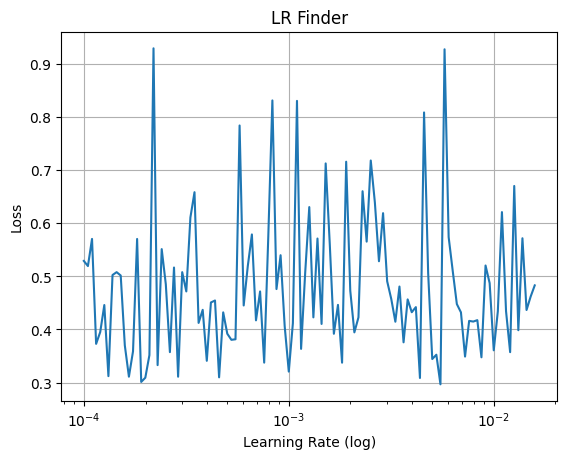

In [22]:
print(f"Device: {device}")
lrs, losses = lrFinder(model, torch.optim.AdamW, BCEDiceLoss(), train_loader, device,start_lr=1e-4,num_iter=200)

plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (log)")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.grid()
plt.show()

# Train the model

In [23]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            reset_weights(layer)  # aplica recursivamente

In [28]:
reset_weights(model)

In [27]:
model

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout2d(p=0.05, inplace=False)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [29]:
criterion = BCEDiceLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4,weight_decay=5e-4)
epochs = 20

print(f"Device: {device}")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        #loss = criterion(outputs.squeeze(1), masks.squeeze(1))
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

Device: cuda:2
Epoch 1/20 - Loss: 0.4729
Epoch 2/20 - Loss: 0.4318
Epoch 3/20 - Loss: 0.4243
Epoch 4/20 - Loss: 0.4188
Epoch 5/20 - Loss: 0.3963
Epoch 6/20 - Loss: 0.3986
Epoch 7/20 - Loss: 0.4007
Epoch 8/20 - Loss: 0.4036
Epoch 9/20 - Loss: 0.3950
Epoch 10/20 - Loss: 0.3980
Epoch 11/20 - Loss: 0.4011
Epoch 12/20 - Loss: 0.3897
Epoch 13/20 - Loss: 0.3696
Epoch 14/20 - Loss: 0.3699
Epoch 15/20 - Loss: 0.3686
Epoch 16/20 - Loss: 0.3752
Epoch 17/20 - Loss: 0.3597
Epoch 18/20 - Loss: 0.3676
Epoch 19/20 - Loss: 0.3567
Epoch 20/20 - Loss: 0.3495


In [30]:
# Save weights
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
weightsFile = os.path.join(weights_path, f"weights_{timestamp}.pth")

os.makedirs(os.path.dirname(weightsFile), exist_ok=True)
torch.save(model.state_dict(), weightsFile)
print(f"Weights saved: {weightsFile}")

Weights saved: /home/lcervantes/Dataset/Datasets/AI4boundariesDS/weights/weights_20250617_154555.pth


In [39]:
predict_th = 0.5

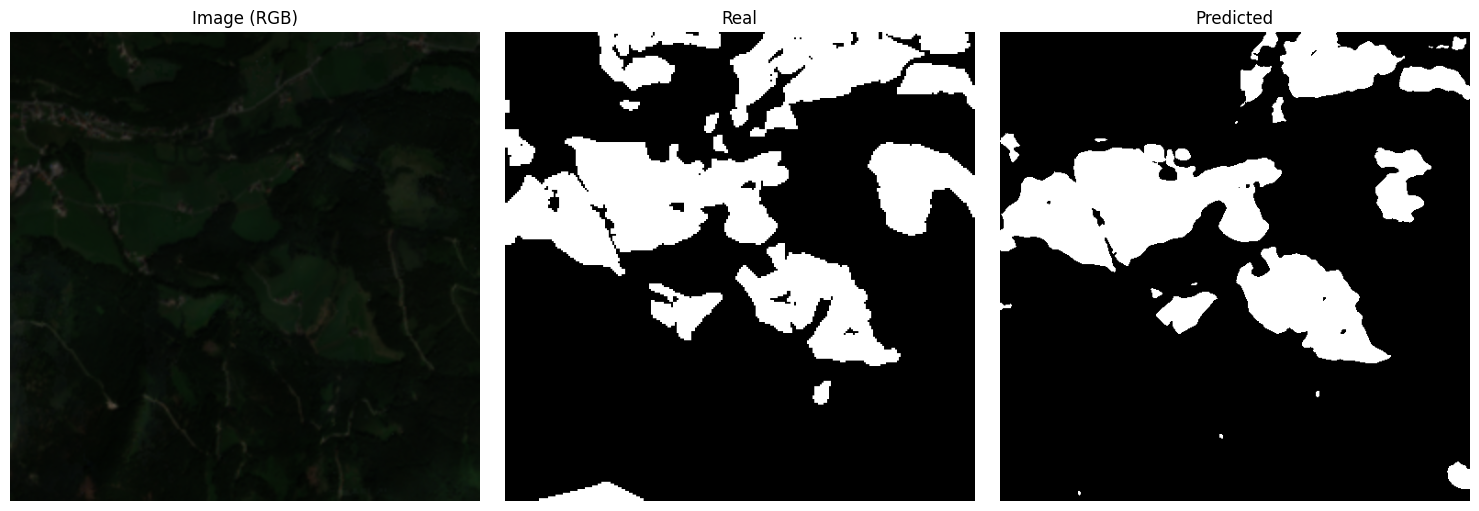

In [40]:
# Eval and visualize
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(test_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs > predict_th).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Image (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicted')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Empty cache and model
del model
gc.collect()
torch.cuda.empty_cache()

# Find metrics

In [25]:
!ls /home/lcervantes/Dataset/Datasets/AI4boundariesDS/weights

20250604		     weights_20250606_202136.pth
20250606		     weights_20250606_204240.pth
weights_20250606_170912.pth  weights_20250606_210647.pth
weights_20250606_180112.pth  weights_20250606_212626.pth
weights_20250606_182253.pth  weights_20250617_154555.pth
weights_20250606_194852.pth


In [26]:
model_pth = "/home/lcervantes/Dataset/Datasets/AI4boundariesDS/weights/weights_20250617_154555.pth"

In [27]:
#Load model weights
model = UNet(in_channels=5, out_channels=1).to(device)
model.load_state_dict(torch.load(model_pth, map_location=device))
model.eval()

UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout2d(p=0.05, inplace=False)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.05, inplace=False)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

In [41]:
device = torch.device("cpu")
torchsummary.summary(model.to("cpu"), input_size=(4, 512, 512), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           2,368
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         Dropout2d-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,928
       BatchNorm2d-6         [-1, 64, 512, 512]             128
              ReLU-7         [-1, 64, 512, 512]               0
         Dropout2d-8         [-1, 64, 512, 512]               0
        DoubleConv-9         [-1, 64, 512, 512]               0
        MaxPool2d-10         [-1, 64, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]          73,856
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        Dropout2d-14        [-1, 128, 2

In [44]:
print(torch.cuda.is_available())
device = torch.device(2 if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

True
Device: cuda:2


In [46]:
#Get all predictions of binary masks and save them in the predictions dir
currentPredictions = os.path.join(predictions_path, "preds_20250617_154555")
os.makedirs(currentPredictions, exist_ok=True)
with torch.no_grad():
    for idx, (img, _) in enumerate(test_loader):
        img = img.to(device)
        output = model(img)
        pred = torch.sigmoid(output)
        pred = (pred > predict_th).float()

        save_image(pred, os.path.join(currentPredictions, f"pred_{idx:03d}.png"))

In [29]:
def compute_metrics(pred, target):
    pred = pred.cpu().numpy().astype(np.uint8).flatten()
    target = target.cpu().numpy().astype(np.uint8).flatten()

    jaccard = jaccard_score(target, pred, zero_division=0)
    precision = precision_score(target, pred, zero_division=0)
    recall = recall_score(target, pred, zero_division=0)
    dice = f1_score(target, pred, zero_division=0)

    return {
        "Jaccard": jaccard,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall
    }

In [30]:
predict_th = 0.5

In [31]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()
        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [32]:
print("Train Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Train Metrics
Jaccard: 0.6615
Dice: 0.7844
Precision: 0.8420
Recall: 0.7514


In [33]:
metrics_list = []

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        pred = (torch.sigmoid(output) > predict_th).float()

        metrics = compute_metrics(pred, mask)
        metrics_list.append(metrics)

In [34]:
print("Test Metrics")
avg_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Test Metrics
Jaccard: 0.4654
Dice: 0.5571
Precision: 0.6533
Recall: 0.5409
